# CSCE633 Machine Learning - HW3

## Programming: Question 3 - 50 points
In this problem, we will use university application data for the purpose of admission classi- fication. Fine data train and data test on canvas.

### Import all the libraries

In [1]:
import os
import cvxopt
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### (a) Data Pre-processing: 
Create a binary label based on the column “Chance of Admit”. Convert any values bigger than the median to 1 and 0 otherwise. Split the data into training and validation sets. You can use a 80-20 split.

#### Read the data
Put the data_train-2.csv and data_test-2.csv under the root directory or inside a data folder.

In [2]:
train_data_path = "./data/data_train-2.csv"
test_data_path = "./data/data_test-2.csv"
out_path = "./Mu-Ruei_Tseng_preds.csv"

if not os.path.exists(train_data_path):
    train_data_path = "./data_train-2.csv"

if not os.path.exists(test_data_path):
    test_data_path = "./data_test-2.csv"
    
assert os.path.exists(train_data_path) and os.path.exists(test_data_path),"Data not found." 

print("Reading train data from: {}".format(train_data_path))
print("Reading test data from: {}".format(test_data_path))


Reading train data from: ./data/data_train-2.csv
Reading test data from: ./data/data_test-2.csv


In [3]:
train_df = pd.read_csv(train_data_path, index_col=0)
test_df = pd.read_csv(test_data_path, index_col=0)
num_rows = 5 # 
print("First {} rows of the training data: ".format(num_rows))
print(train_df.head(n=num_rows))

print("=================================================================================")

print("First {} rows of the test data: ".format(num_rows))
print(test_df.head(n=num_rows))
print("=================================================================================")
print("The shape of the training dataframe: {}".format(train_df.shape))
print("The shape of the testing dataframe: {}".format(test_df.shape))

First 5 rows of the training data: 
   Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
0         109        331          116                  5  5.0   5.0  9.38   
1         346        316           98                  1  1.5   2.0  7.43   
2          99        332          119                  4  5.0   4.5  9.24   
3         210        301          104                  3  3.5   4.0  8.12   
4         242        317          103                  2  2.5   2.0  8.15   

   Research  Chance of Admit   
0         1              0.93  
1         0              0.49  
2         1              0.90  
3         1              0.68  
4         0              0.65  
First 5 rows of the test data: 
   Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
0         328        295          101                  2  2.5   2.0  7.86   
1         325        315          104                  3  3.0   2.5  8.33   
2         191        324          111         

#### Create binary label based on the column “Chance of Admit”. 
Convert any values bigger than the median to 1 and 0 otherwise

In [4]:
label_col = "Chance of Admit "
feature_cols = train_df.columns.drop(['Serial No.', label_col])
features = train_df[feature_cols]
label = train_df[label_col]
median_label = label.median()
label = (label>median_label).astype(int)

print("=================================================================================")
print("The feature columns: ")
print(features.head(n=5))
print("=================================================================================")
print("The label column: ")
print(label.head(n=5))


The feature columns: 
   GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  Research
0        331          116                  5  5.0   5.0  9.38         1
1        316           98                  1  1.5   2.0  7.43         0
2        332          119                  4  5.0   4.5  9.24         1
3        301          104                  3  3.5   4.0  8.12         1
4        317          103                  2  2.5   2.0  8.15         0
The label column: 
0    1
1    0
2    1
3    0
4    0
Name: Chance of Admit , dtype: int64


#### Split the data into training and validation sets.
Use a 80-20 split.

In [5]:
split_ratio = 0.8

random.seed(42)
train_idx = random.sample(range(len(train_df)), int(len(train_df)*split_ratio))
val_idx = list(set(range(len(train_df))) - set(train_idx))

train_features = features.iloc[train_idx]
train_label = label.iloc[train_idx]

val_features = features.iloc[val_idx]
val_label = label.iloc[val_idx]

print("=================================================================================")
print("The shape of the training features: {}".format(train_features.shape))
print("The shape of the training labels: {}".format(train_label.shape))
print("The shape of the validation features: {}".format(val_features.shape))
print("The shape of the validation labels: {}".format(val_label.shape))
print("=================================================================================")

The shape of the training features: (256, 7)
The shape of the training labels: (256,)
The shape of the validation features: (64, 7)
The shape of the validation labels: (64,)


#### Show the feature distribution

In [6]:
def isCategorical(column_name):
    categorical_features = [
        'SOP',
        'LOR ',
        'University Rating',
        'Research',
    ]
    return column_name in categorical_features

    
def plot_histogram(features):
    num_features = features.shape[1]
    feature_columns = features.columns
    
    plot_columns = 4
    plot_rows = num_features // plot_columns + (num_features % plot_columns > 0)
    fig, axes = plt.subplots(plot_rows, plot_columns, figsize=(15, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i in range(num_features):
        ax = axes[i // plot_columns, i % plot_columns]
        is_categorical = isCategorical(feature_columns[i])
        
        if is_categorical:
            # For categorical data, use value_counts to get a bar chart
            category_counts = features.iloc[:, i].value_counts()
            # sort the index to make sure the order is consistent
            category_counts = category_counts.sort_index()
            str_category_counts = category_counts.index.astype(str)
            ax.bar(str_category_counts, category_counts, width=0.5, edgecolor='black')
        else:
            # For numerical data, automatically determine the bin size
            bins = min(int(np.sqrt(features.iloc[:, i].shape[0])), 50)
            ax.hist(features.iloc[:, i], bins=bins, edgecolor='black')

        ax.set_title(feature_columns[i])

    # remove the empty subplots if the number of features is not a multiple of `plot_columns`
    for i in range(num_features, plot_rows * plot_columns):
        fig.delaxes(axes.flatten()[i])

    plt.suptitle("Histogram of the features", fontsize=16, y=1.02)
    fig.legend(["Histogram"], loc="lower right")

    plt.tight_layout()
    plt.show()

    return

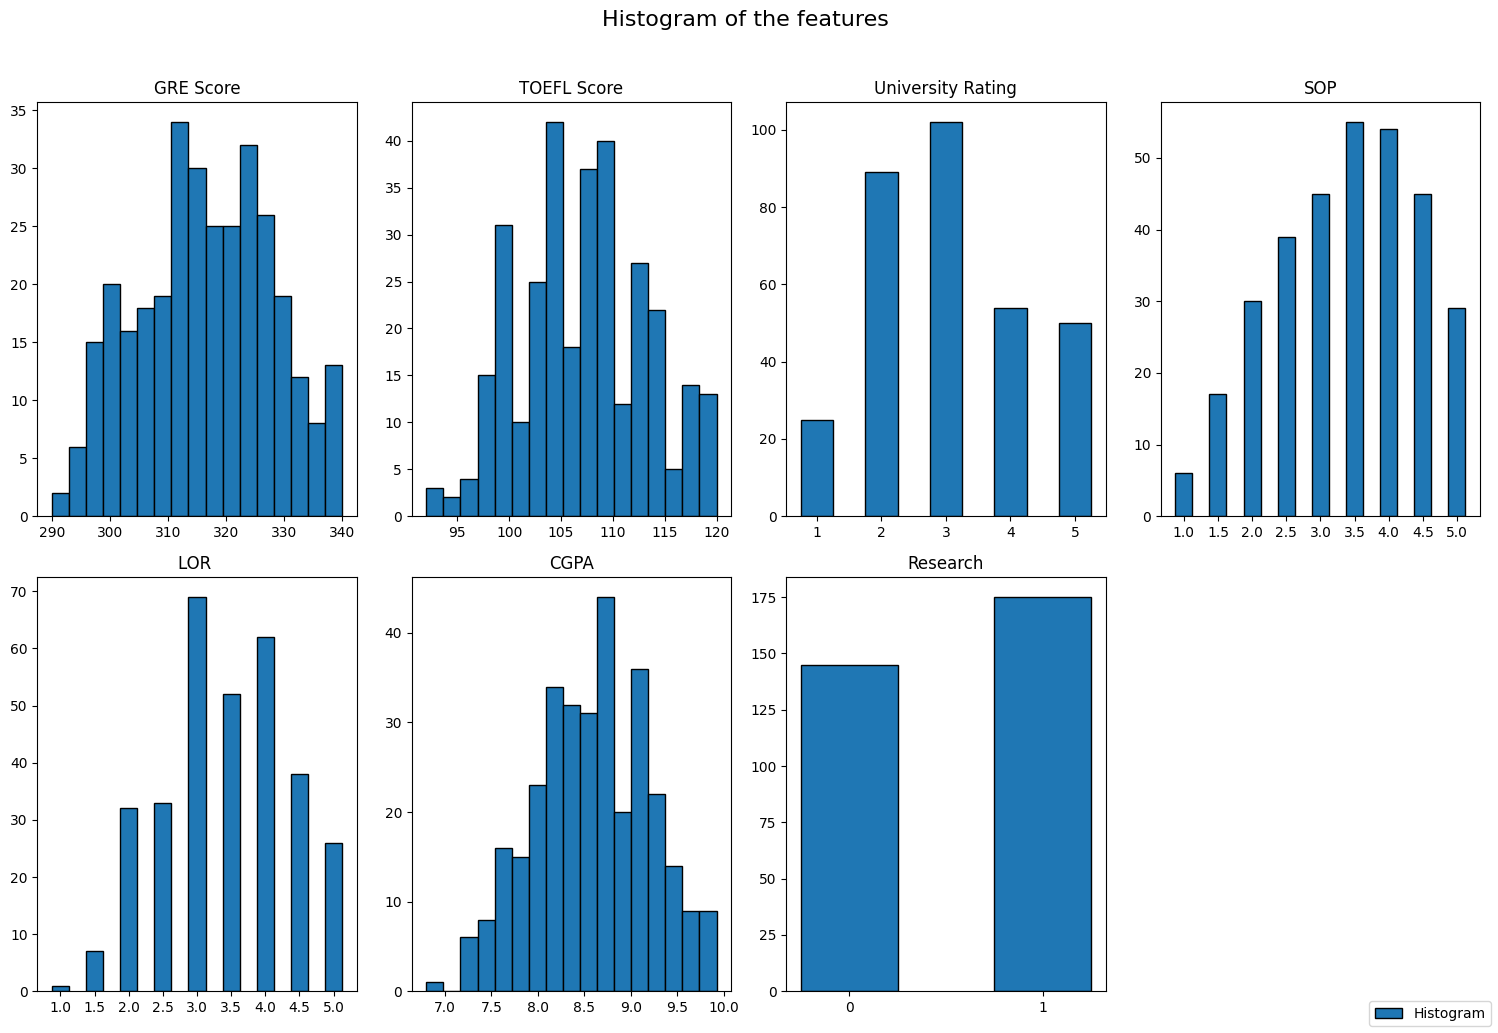

In [7]:
plot_histogram(features)

From the histogram, we can see that there are two types of data in the features:
* Continuous Data
    - GRE Score
    - TOEFL Score
    - CGPA
* Categorical Data
    - SOP: Statement of Purpose raing
    - LOR: Letter of Recommendation rating
    - University Rating
    - Research
    
We perform normalization for continuous data on X_train.

#### Normalize the data for continuous features

In [8]:
continuous_features = [ col for col in features.columns if not isCategorical(col)]
mean_features = train_df[continuous_features].mean()
std_features = train_df[continuous_features].std()

print("=================================================================================")
print("The mean of the features: ")
print(mean_features)
print("=================================================================================")
print("The standard deviation of the features: ")
print(std_features)

The mean of the features: 
GRE Score      316.503125
TOEFL Score    107.181250
CGPA             8.581719
dtype: float64
The standard deviation of the features: 
GRE Score      11.719554
TOEFL Score     6.172415
CGPA            0.608528
dtype: float64


### (b) Model Initialization: 
Initialize 4 different SVM models with the following kernels.
1. Linear kernel
2. RBF kernel
3. Polynomial (degree 3) kernel

For an SVM, our objective is to find the maximum margin between the separating hyperplane and the closest points of the input space (support vectors). The optimization problem can be formulated as follows:

The hyperplane is defined as:
$$
w_0 + w^T x = 0
$$
The negative hyperplane is:
$$
w_0 + w^T x = -1
$$
The positive hyperplane is:
$$
w_0 + w^T x = 1
$$
The margin $c$ is given by:
$$
c = \frac{2}{||w||}
$$

To maximize $c$ is to minimize $||w||$, or equivalently, to minimize $\frac{1}{2}||w||^2$. This is done under the constraint that all data points $x_i$ are classified correctly, i.e. subject to $y_i (w^T x_i + w_0)>=1$. Therefore, we can rewrite the problem as a quadratic optimization problem where:

$$
\begin{cases}
      \text{minimize:} \frac{1}{2}||w||^2 \\
      \text{subject to } 1-(w_0+w^Tx)y_i \leq 0
    \end{cases}
$$

The Lagrangian of this problem, incorporating the Lagrange multipliers $\alpha_i$ for the inequality constraints, is:
$$
\mathcal{L}(w_0, w, \alpha) = \frac{1}{2}||w||^2 - \sum^n_{i=1}\alpha_i(y_i(w_0+w^Tx)-1)
$$

Minimize the Lagrangian to solve for the $w$ and $w_0$ gives as:
$$
\begin{gather}
      \frac{\partial \mathcal{L}}{\partial w} = 0 \rightarrow w = \sum^n_{i=1}\alpha_i y_i x_i \\
      \frac{\partial \mathcal{L}}{\partial w_0} = 0 \rightarrow 0 = \sum^n_{i=1}\alpha_i y_i 
    \end{gather}
$$
Substitute $w$ and $w_0$ in the original Lagrangian equation and express in terms of dual variables $\alpha_i$, we transform the primal problem to the dual problem in which we should maximuize the Lagrangian with respect to the dual variables.
$$
\max_\alpha W(\alpha) = \mathcal{L}(w_0, w, \alpha) = \sum^n_{i=1}\alpha_i y_i  - \frac{1}{2}\sum^n_{i=1}\sum^n_{j=1}\alpha_i\alpha_j y_i y_j x^T_i x_j
$$
subject to: $\alpha_i \geq 0 \text{  } \forall i$ and $\sum^n_{i=1} \alpha_i y_i = 0$

We are maximizing the dual objective function subject to the dual constraints, which is equivalent to minimizing $-W(\alpha)$. This dual form is what is solved using quadratic programming solvers like `cvxopt.solvers.qp`.

Quadratic programming problems are typically framed as minimization problems. The standard form for a QP problem is:
$$
\min_\alpha \frac{1}{2}\alpha^TP\alpha + q^T \alpha
$$
subject to $G(\alpha) \leq h$ and $A\alpha = b$. In SVM, the corresponding $P, q, G, h, A, b$ are:
* $P_{ij} = y_iy_jK(x_i,x_j)$, where $K(x_i,x_j)$ is the kernel function
* $q = -1$
* $G$ is a combination of a negative identity matrix and an identity matrix and to enforce $0\leq \alpha_i \leq C$, i.e. 
$
\begin{bmatrix}
-I_n \\
I_n
\end{bmatrix}
$
* $h$ combines a zero vector and a $C\times 1$, i.e. 
$
\begin{bmatrix}
\vec{0} \in R^n \\
C \in R^n
\end{bmatrix}
$
* A is a transpose of the label vector $y$ to enforce the $\sum^n_{i=1} \alpha_i y_i = 0$ constraint
* b is a zero scalar (as we are enforcing equality to 0)

After we find the $\alpha$ that minimize the QP problem, we can find the support vectors which are points with $\alpha_i > 0$.

We can obtain our <b>decision function</b>: 
$$
f(x) = \text{sign}(\sum_{sv}\alpha_{sv}y_{sv}K(x,x_{sv})+ w_0)
$$
, where $sv$ are the indices of the support vectors, $\alpha_{sv}$ are the Lagrange multipliers for the support vectors, $y_{sv}$ are labels of the support vectors, and $x_{sv}$ are the support vectors. $w_0$ is the intercept term which can be calculated as
$$
w_0 = \frac{1}{N}\sum_{s\in sv}(y_s - \sum_{s'\in sv}\alpha_{s'}y_{s'}K(x,x_{s'}))
$$


In [9]:
class SVM:
    def __init__(self, kernel, C = 1):
        self.C = C
        self.kernel = kernel
        self.X_mean = None
        self.X_std = None
    
    def preprocess(self, X):
        if self.X_mean is None:
            raise ValueError("The model has not been trained yet.")
        
        if isinstance(X, pd.DataFrame):
            for col in self.continuous_features:
                X[col] = (X[col] - self.X_mean[col]) / self.X_std[col]
            X = X.values
        else:
            if len(X.shape) == 1:
                X = X.values.reshape(-1, 1)
                X = np.where(X == 0, -1, 1)
            else:
                for i in range(len(self.features)):
                    if not isCategorical(self.features[i]):
                        X[:, i] = (X[:, i] - self.X_mean[self.features[i]]) / self.X_std[self.features[i]]
        return X


    def fit(self, X, y):
        # calculate the mean and standard deviation of the features
        X = X.copy()
        y = y.copy()
        self.features = X.columns
        self.continuous_features = [ col for col in self.features if not isCategorical(col)]

        self.X_mean = X[self.continuous_features].mean()
        self.X_std = X[self.continuous_features].std()
        
        
        X = self.preprocess(X)
        y = self.preprocess(y)

        self.X = X
        self.y = y
        n      = X.shape[0]
        self.n = n

        # P and q
        P = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                P[i][j] = y[i, 0]*y[j, 0]*self.kernel(X[i, :], X[j, :])
        q = -np.ones((n, 1))

        # G and h
        G = np.vstack([np.diag([-1 for _ in range(n)]), np.eye(n)])
        h = np.vstack([np.zeros((n, 1)), self.C * np.ones((n, 1))])

        # A and b
        A = y.T
        b = np.zeros((1,1))


        # casting all matrices to CVXOPT matrices
        P, q, G, h, A, b = [cvxopt.matrix(m.astype('double')) for m in [P, q, G, h, A, b]]


        # calling cvxopt solver using the matrices we have built
        sol = cvxopt.solvers.qp(P, q, G, h, A, b, options={'show_progress': False})

        # extracting alpha values from the solver output
        self.alpha = np.array(sol['x']).reshape(self.n)

        # support vectors are points with \alpha_i > 0
        sup_vecs = np.where(self.alpha > 1e-4)[0]
        self.sup_vecs = sup_vecs
        self.positive_sup_vecs = np.where(y[sup_vecs, 0] == 1)[0]
        self.negative_sup_vecs = np.where(y[sup_vecs, 0] == -1)[0]

        # calculating w0
        self.w0 = np.mean([
            y[sv, 0] - sum(self.alpha[sv_]*y[sv_, 0]*self.kernel(X[sv, :], X[sv_, :]) for sv_ in sup_vecs)
            for sv in sup_vecs
        ])

    def _predict(self, x):
        return np.sign(sum([self.alpha[sv]*self.y[sv, 0]*self.kernel(x, self.X[sv, :])for sv in self.sup_vecs])+self.w0)


    def predict(self, X):
        X = X.copy()
        X = self.preprocess(X)
        y_pred = np.array([self._predict(X[i, :]) for i in range(X.shape[0])])

        return np.where(y_pred == -1, 0, 1)


#### Kernel Functions

Assume that $x = [x_1, x_2, ..., x_k]$
1. Linear Kernel:
$$
K(x_i,x_j) = x_i \cdot x_j
$$

2. RBF Kernel (Radoa basis function, Gaussian Kernel):
$$
K(x_i,x_j) = e^{-\frac{||x_i-x_j||^2}{2\sigma^2}}
$$
, where $\sigma$ is the standard deviation of the gaussian function.

3. Polynomial Kernel:
$$
K(x_i,x_j, c) = (x_i \cdot x_j+c)^d
$$
, where $c\geq 0$ and $d$ is the degree. In here, we use a polynomial kernel of degree 3 and $c=1$.


In [10]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def RBF_kernel(x1, x2, sigma = 1):
    return np.exp(-np.linalg.norm(x1-x2)**2/(2*sigma**2))

def polynomial_kernel(x1, x2, p = 3, c = 1):
    return (c+np.dot(x1, x2))**p

#### Initialize the models


In [11]:
svm_linear = SVM(kernel=linear_kernel, C=1)
svm_rbf = SVM(kernel=RBF_kernel, C=1)
svm_poly = SVM(kernel=polynomial_kernel, C=1)


### (c) Feature Selection and Model Training: 
Train each SVM Model above with the following feature combinations to predict admission.
1. CGPA and SOP
2. CGPA and GRE Score 
3. SOP and LOR
4. LOR and GRE Score

In [12]:
models = {
    'CGPA_SOP':{
        'features': ['CGPA', 'SOP'],
    },
    'CGPA_GRE':{
        'features': ['CGPA', 'GRE Score'],
    },
    'SOP_LOR':{
        'features': ['SOP', 'LOR '],
    },
    'LOR_GRE':{
        'features': ['LOR ', 'GRE Score'],
    },
}

#### 1. CGPA and SOP

In [13]:
selected_features = ['CGPA', 'SOP']
train_features = train_df.loc[train_idx, selected_features]
train_label = label[train_idx]
val_features = train_df.loc[val_idx, selected_features]
val_label = label[val_idx]

svm_linear = SVM(kernel=linear_kernel, C=1)
svm_rbf = SVM(kernel=RBF_kernel, C=1)
svm_poly = SVM(kernel=polynomial_kernel, C=1)


In [14]:
# train the models
svm_linear.fit(train_features, train_label)
svm_rbf.fit(train_features, train_label)
svm_poly.fit(train_features, train_label)

#### Verify with SVC from sklearn

In [15]:
from sklearn.svm import SVC

sklearn_svm_linear = SVC(kernel='linear', C=1)
sklearn_svm_rbf = SVC(kernel='rbf', C=1)
sklearn_svm_poly = SVC(kernel='poly', C=1, degree=3)

In [16]:
# Train the sklearn SVM models
sklearn_svm_linear.fit(train_features, train_label.values)
sklearn_svm_rbf.fit(train_features, train_label.values)
sklearn_svm_poly.fit(train_features, train_label.values)

SVC(C=1, kernel='poly')

In [17]:
# Predict the training data
svm_linear_preds = svm_linear.predict(train_features)
svm_rbf_preds = svm_rbf.predict(train_features)
svm_poly_preds = svm_poly.predict(train_features)

sklearn_svm_linear_preds = sklearn_svm_linear.predict(train_features)
sklearn_svm_rbf_preds = sklearn_svm_rbf.predict(train_features)
sklearn_svm_poly_preds = sklearn_svm_poly.predict(train_features)

def error_rate(preds, labels):
    return np.mean(preds != labels)

print("Verifying the result with sklearn SVM")
print("=================================================================================")
print("Linear SVM")
print("Difference: {}".format(error_rate(svm_linear_preds, sklearn_svm_linear_preds)))
print("=================================================================================")
print("RBF SVM")
print("Difference: {}".format(error_rate(svm_rbf_preds, sklearn_svm_rbf_preds)))
print("=================================================================================")
print("Polynomial SVM")
print("Difference: {}".format(error_rate(svm_poly_preds, sklearn_svm_poly_preds)))
print("=================================================================================")

Verifying the result with sklearn SVM
Linear SVM
Difference: 0.03125
RBF SVM
Difference: 0.0390625
Polynomial SVM
Difference: 0.02734375


In [18]:
models["CGPA_SOP"]["Linear"] = svm_linear
models["CGPA_SOP"]["RBF"] = svm_rbf
models["CGPA_SOP"]["Polynomial"] = svm_poly

#### 2. CGPA and GRE Score 

In [19]:
svm_linear = SVM(kernel=linear_kernel, C=1)
svm_rbf = SVM(kernel=RBF_kernel, C=1)
svm_poly = SVM(kernel=polynomial_kernel, C=1)


selected_features = ['CGPA', 'GRE Score']
train_features = train_df.loc[train_idx, selected_features]
train_label = label[train_idx]

val_features = train_df.loc[val_idx, selected_features]
val_label = label[val_idx]



In [20]:
print("Trainining svm_linear model~")
svm_linear.fit(train_features, train_label)
print("Trainining svm_rbf model~")
svm_rbf.fit(train_features, train_label)
print("Trainining svm_poly model~")
svm_poly.fit(train_features, train_label)

# Save the models
models["CGPA_GRE"]["Linear"] = svm_linear
models["CGPA_GRE"]["RBF"] = svm_rbf
models["CGPA_GRE"]["Polynomial"] = svm_poly

Trainining svm_linear model~
Trainining svm_rbf model~
Trainining svm_poly model~


#### 3. SOP and LOR

In [21]:
svm_linear = SVM(kernel=linear_kernel, C=1)
svm_rbf = SVM(kernel=RBF_kernel, C=1)
svm_poly = SVM(kernel=polynomial_kernel, C=1)

selected_features = ['SOP', 'LOR ']
train_features = train_df.loc[train_idx, selected_features]
train_label = label[train_idx]

svm_linear.fit(train_features, train_label)
svm_rbf.fit(train_features, train_label)
svm_poly.fit(train_features, train_label)

# Save the models
models["SOP_LOR"]["Linear"] = svm_linear
models["SOP_LOR"]["RBF"] = svm_rbf
models["SOP_LOR"]["Polynomial"] = svm_poly

#### 4. LOR and GRE Score

In [22]:
svm_linear = SVM(kernel=linear_kernel, C=1)
svm_rbf = SVM(kernel=RBF_kernel, C=1)
svm_poly = SVM(kernel=polynomial_kernel, C=1)

selected_features = ['LOR ', 'GRE Score']
train_features = train_df.loc[train_idx, selected_features]
train_label = label[train_idx]
val_features = train_df.loc[val_idx, selected_features]
val_label = label[val_idx]

print("Trainining svm_linear model~")
svm_linear.fit(train_features, train_label)
print("Trainining svm_rbf model~")
svm_rbf.fit(train_features, train_label)
print("Trainining svm_poly model~")
svm_poly.fit(train_features, train_label)

# Save the models
models["LOR_GRE"]["Linear"] = svm_linear
models["LOR_GRE"]["RBF"] = svm_rbf
models["LOR_GRE"]["Polynomial"] = svm_poly

Trainining svm_linear model~
Trainining svm_rbf model~
Trainining svm_poly model~


### (d) Support Vectors: 
What are the support vectors for each model and feature combination? How many support vectors does each class have in each case?

In [23]:
for key in models.keys():
    print("Features: {}".format(models[key]["features"]))
    for model in list(set(models[key].keys()) - set(["features"])):
        support_vectors = models[key][model].sup_vecs
        positive_support_vectors = models[key][model].positive_sup_vecs
        negative_support_vectors = models[key][model].negative_sup_vecs
        print("Model: {}, Number of support vectors: {} (positive: {}, negative: {})".format(model, len(support_vectors), len(positive_support_vectors), len(negative_support_vectors)))
    print("=================================================================================")

Features: ['CGPA', 'SOP']
Model: Polynomial, Number of support vectors: 89 (positive: 44, negative: 45)
Model: Linear, Number of support vectors: 92 (positive: 46, negative: 46)
Model: RBF, Number of support vectors: 101 (positive: 48, negative: 53)
Features: ['CGPA', 'GRE Score']
Model: Polynomial, Number of support vectors: 83 (positive: 40, negative: 43)
Model: Linear, Number of support vectors: 83 (positive: 41, negative: 42)
Model: RBF, Number of support vectors: 93 (positive: 46, negative: 47)
Features: ['SOP', 'LOR ']
Model: Polynomial, Number of support vectors: 131 (positive: 67, negative: 64)
Model: Linear, Number of support vectors: 140 (positive: 73, negative: 67)
Model: RBF, Number of support vectors: 156 (positive: 80, negative: 76)
Features: ['LOR ', 'GRE Score']
Model: Polynomial, Number of support vectors: 88 (positive: 44, negative: 44)
Model: Linear, Number of support vectors: 92 (positive: 48, negative: 44)
Model: RBF, Number of support vectors: 101 (positive: 49, n

### (e) Result Visualization: 
For each kernel - input combination, visualize the predictions on the training set. Color code the points by their labels.

In [24]:
def plot(ax, X, y, title, xlabel="", ylabel="", model=None, h=0.05, pad=0.25, legend=False):

    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
    if model is not None:
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        # red for 0, blue for 1
        ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.2)

    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolor='k')

    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if legend:
        class_labels = ['Not Admitted', 'Admitted']
        # Create a list of the unique values in `y` and their corresponding colors from the colormap
        unique_y = np.unique(y)
        colors = [plt.cm.coolwarm(i) for i in np.linspace(0, 1, len(unique_y))]
        # Create custom legend entries
        custom_entries = [plt.Line2D([0], [0], color=colors[i], marker='o', linestyle='', markersize=10, label=class_labels[i]) for i in range(len(unique_y))]
        ax.legend(handles=custom_entries, title="Classes")
        
    return scatter

#### 1. CGPA and SOP

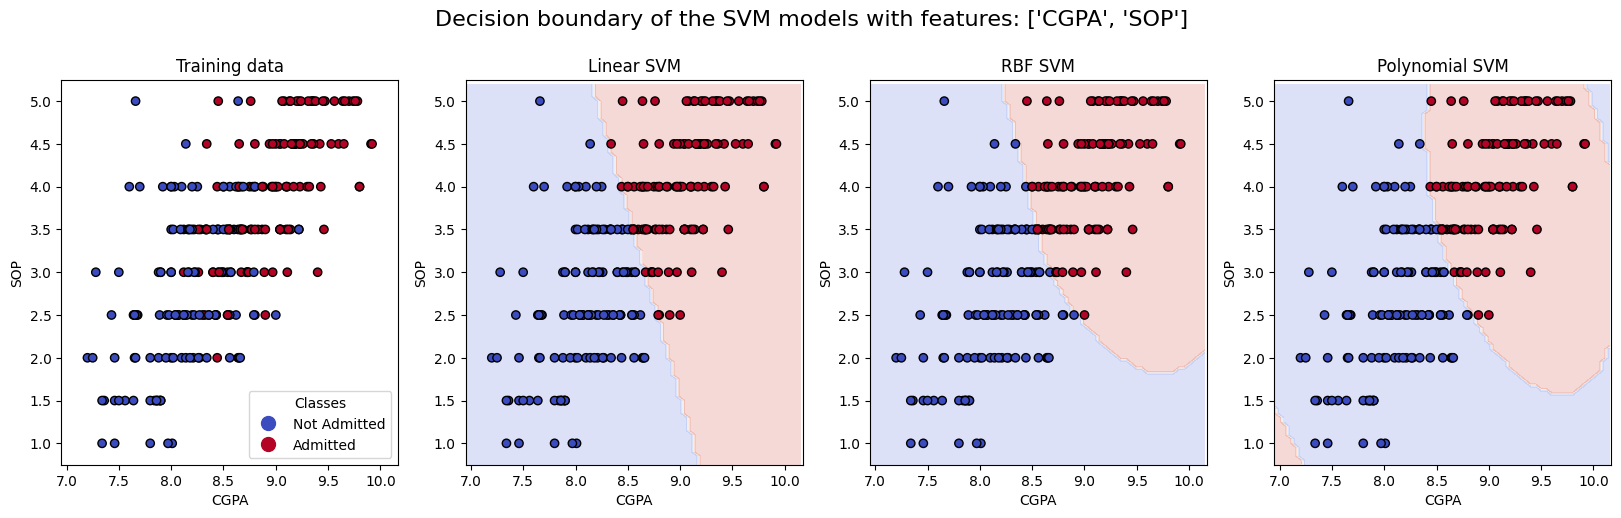

In [25]:
selected_features = ['CGPA', 'SOP']
train_features = train_df.loc[train_idx, selected_features]
train_label = label[train_idx]
feature_key = "{}_{}".format(selected_features[0].split(' ')[0], selected_features[1].split(' ')[0])
svm_linear_preds = models[feature_key]["Linear"].predict(train_features)
svm_rbf_preds = models[feature_key]["RBF"].predict(train_features)
svm_poly_preds = models[feature_key]["Polynomial"].predict(train_features)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
plot(axes[0], train_features.values, train_label, "Training data", xlabel=selected_features[0], ylabel=selected_features[1], legend=True)
plot(axes[1], train_features.values, svm_linear_preds, "Linear SVM", xlabel=selected_features[0], ylabel=selected_features[1], model=models[feature_key]["Linear"])
plot(axes[2], train_features.values, svm_rbf_preds, "RBF SVM", xlabel=selected_features[0], ylabel=selected_features[1], model=models[feature_key]["RBF"])
plot(axes[3], train_features.values, svm_poly_preds, "Polynomial SVM", xlabel=selected_features[0], ylabel=selected_features[1], model=models[feature_key]["Polynomial"])


plt.suptitle("Decision boundary of the SVM models with features: {}".format(selected_features), fontsize=16, y=1.02)
plt.show()

#### 2. CGPA and GRE Score 

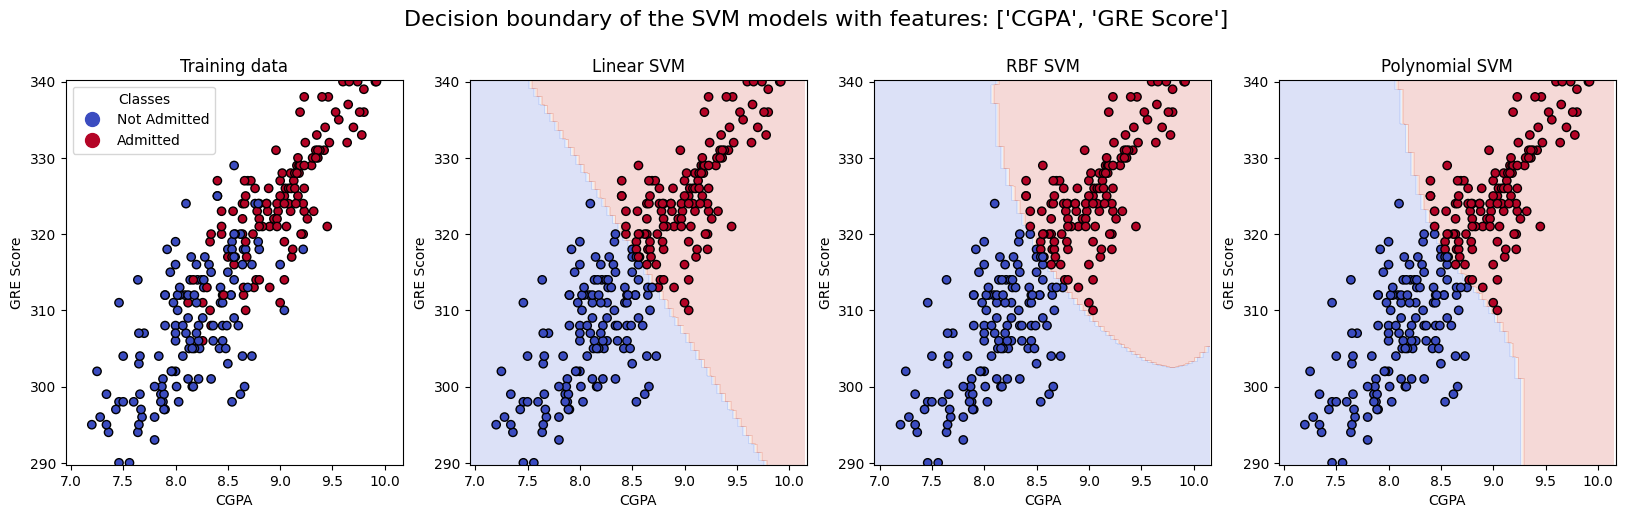

In [26]:
selected_features = ['CGPA', 'GRE Score']
train_features = train_df.loc[train_idx, selected_features]
train_label = label[train_idx]
feature_key = "{}_{}".format(selected_features[0].split(' ')[0], selected_features[1].split(' ')[0])
svm_linear_preds = models[feature_key]["Linear"].predict(train_features)
svm_rbf_preds = models[feature_key]["RBF"].predict(train_features)
svm_poly_preds = models[feature_key]["Polynomial"].predict(train_features)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
plot(axes[0], train_features.values, train_label, "Training data", xlabel=selected_features[0], ylabel=selected_features[1], legend=True)
plot(axes[1], train_features.values, svm_linear_preds, "Linear SVM", xlabel=selected_features[0], ylabel=selected_features[1], model=models[feature_key]["Linear"])
plot(axes[2], train_features.values, svm_rbf_preds, "RBF SVM", xlabel=selected_features[0], ylabel=selected_features[1], model=models[feature_key]["RBF"])
plot(axes[3], train_features.values, svm_poly_preds, "Polynomial SVM", xlabel=selected_features[0], ylabel=selected_features[1], model=models[feature_key]["Polynomial"])

plt.suptitle("Decision boundary of the SVM models with features: {}".format(selected_features), fontsize=16, y=1.02)
plt.show()

#### SOP and LOR

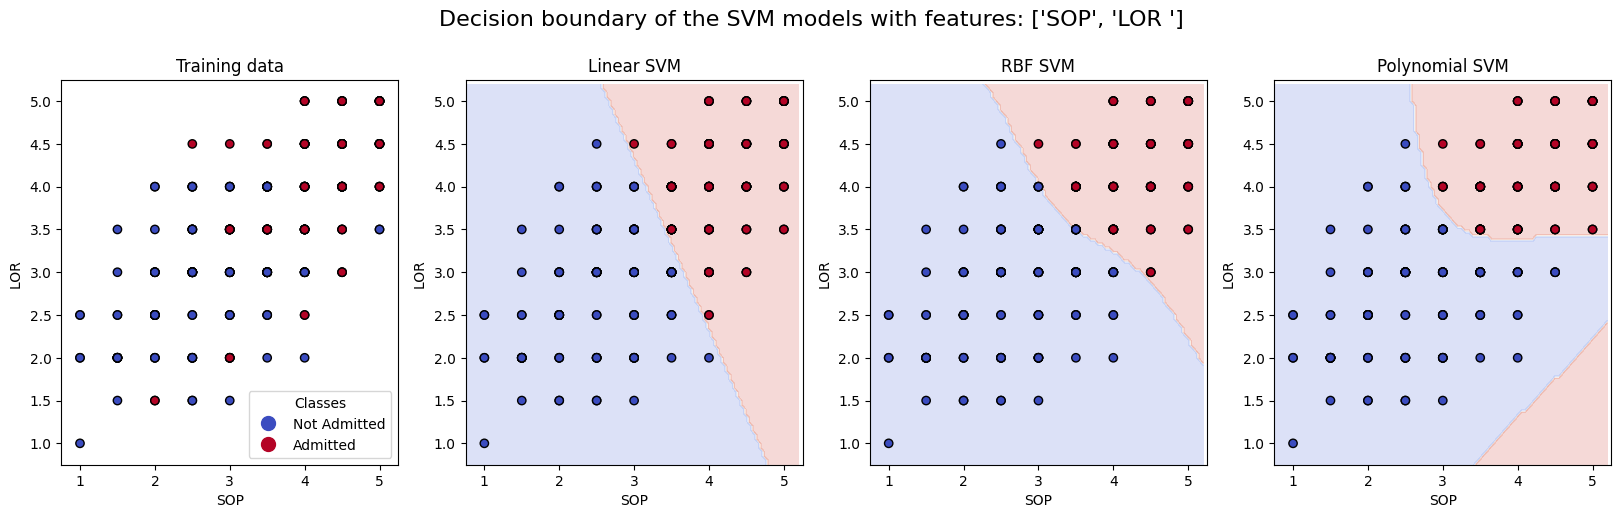

In [27]:
selected_features = ['SOP', 'LOR ']
train_features = train_df.loc[train_idx, selected_features]
train_label = label[train_idx]
feature_key = "{}_{}".format(selected_features[0].split(' ')[0], selected_features[1].split(' ')[0])
svm_linear_preds = models[feature_key]["Linear"].predict(train_features)
svm_rbf_preds = models[feature_key]["RBF"].predict(train_features)
svm_poly_preds = models[feature_key]["Polynomial"].predict(train_features)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
plot(axes[0], train_features.values, train_label, "Training data", xlabel=selected_features[0], ylabel=selected_features[1], legend=True)
plot(axes[1], train_features.values, svm_linear_preds, "Linear SVM", xlabel=selected_features[0], ylabel=selected_features[1], model=models[feature_key]["Linear"])
plot(axes[2], train_features.values, svm_rbf_preds, "RBF SVM", xlabel=selected_features[0], ylabel=selected_features[1], model=models[feature_key]["RBF"])
plot(axes[3], train_features.values, svm_poly_preds, "Polynomial SVM", xlabel=selected_features[0], ylabel=selected_features[1], model=models[feature_key]["Polynomial"])

plt.suptitle("Decision boundary of the SVM models with features: {}".format(selected_features), fontsize=16, y=1.02)
plt.show()

#### LOR and GRE Score

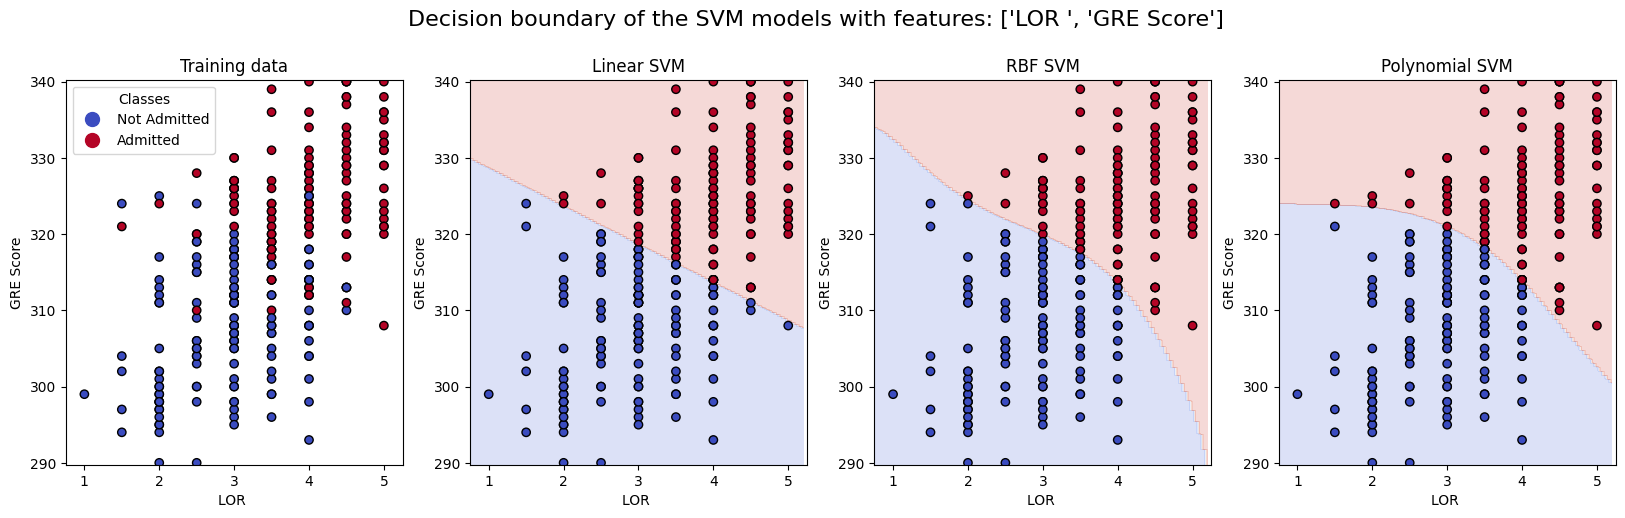

In [28]:
selected_features = ['LOR ', 'GRE Score']
train_features = train_df.loc[train_idx, selected_features]
train_label = label[train_idx]
feature_key = "{}_{}".format(selected_features[0].split(' ')[0], selected_features[1].split(' ')[0])
svm_linear_preds = models[feature_key]["Linear"].predict(train_features)
svm_rbf_preds = models[feature_key]["RBF"].predict(train_features)
svm_poly_preds = models[feature_key]["Polynomial"].predict(train_features)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
plot(axes[0], train_features.values, train_label, "Training data", selected_features[0], selected_features[1], legend=True)
plot(axes[1], train_features.values, svm_linear_preds, "Linear SVM", xlabel=selected_features[0], ylabel=selected_features[1], model=models[feature_key]["Linear"])
plot(axes[2], train_features.values, svm_rbf_preds, "RBF SVM", xlabel=selected_features[0], ylabel=selected_features[1], model=models[feature_key]["RBF"])
plot(axes[3], train_features.values, svm_poly_preds, "Polynomial SVM", xlabel=selected_features[0], ylabel=selected_features[1], model=models[feature_key]["Polynomial"])

plt.suptitle("Decision boundary of the SVM models with features: {}".format(selected_features), fontsize=16, y=1.02)
plt.show()

### (f) Result Analysis: 
Just by looking at the figures you generated, answer this question: Which features + kernel combinations give you the best result? Validate your model on the validation set and find the best performing combination with respect to accuracy.

In [29]:
accuracy = {}
best_accuracy = 0
best_model = {
    'features': None,
    'name': None,
    'model': None,
}

for feature_key in models.keys():
    for model_name in list(set(models[feature_key].keys()) - set(["features"])):
        print("Features: {}, Model: {}".format(models[feature_key]["features"], model_name))
        selected_features = models[feature_key]["features"]

        val_features = train_df.loc[val_idx, selected_features]
        val_label = label[val_idx]
        model = models[feature_key][model_name]

        preds = model.predict(val_features)
        acc = 1 - error_rate(preds, val_label)
        accuracy[(feature_key, model_name)] = acc
        print(" - Accuracy: {}".format(acc))

        if acc > best_accuracy:
            best_accuracy = acc
            best_model = {
                'features': models[feature_key]["features"],
                'name': model_name,
                'model': model,
            }

print("=================================================================================")
print("The best model is: ")
print("Features: {}, Model: {}".format(best_model["features"], best_model["name"]))
print("Accuracy: {}".format(best_accuracy))



Features: ['CGPA', 'SOP'], Model: Polynomial
 - Accuracy: 0.859375
Features: ['CGPA', 'SOP'], Model: Linear
 - Accuracy: 0.859375
Features: ['CGPA', 'SOP'], Model: RBF
 - Accuracy: 0.859375
Features: ['CGPA', 'GRE Score'], Model: Polynomial
 - Accuracy: 0.78125
Features: ['CGPA', 'GRE Score'], Model: Linear
 - Accuracy: 0.796875
Features: ['CGPA', 'GRE Score'], Model: RBF
 - Accuracy: 0.78125
Features: ['SOP', 'LOR '], Model: Polynomial
 - Accuracy: 0.859375
Features: ['SOP', 'LOR '], Model: Linear
 - Accuracy: 0.859375
Features: ['SOP', 'LOR '], Model: RBF
 - Accuracy: 0.875
Features: ['LOR ', 'GRE Score'], Model: Polynomial
 - Accuracy: 0.75
Features: ['LOR ', 'GRE Score'], Model: Linear
 - Accuracy: 0.734375
Features: ['LOR ', 'GRE Score'], Model: RBF
 - Accuracy: 0.734375
The best model is: 
Features: ['SOP', 'LOR '], Model: RBF
Accuracy: 0.875


According to the results, the best model is with features <b>SOP</b> and <b>LOR</b> and using the RBF kernel. In terms of decision boundaries, the RBF kernel typically provides more flexibility and can capture more complex relationships than linear or polynomial kernels, which is one of the possible reasons that it has better performances with the features 'SOP' and 'LOR '. The effectiveness of the RBF kernel is also visually apparent in the decision boundary plot where it seems to better separate the classes compared to the other kernels.

### (g) Inference: 
Use the best model you found in the previous step to predict the label of the test data. Save the prediction in a csv file ”FirstName_LastName_preds.csv”

In [30]:
test_features = test_df[best_model["features"]]
test_preds = best_model["model"].predict(test_features)

predictions_df = pd.DataFrame(columns=["pred_svm"])
predictions_df["pred_svm"] = test_preds
predictions_df.to_csv(out_path, index=False)

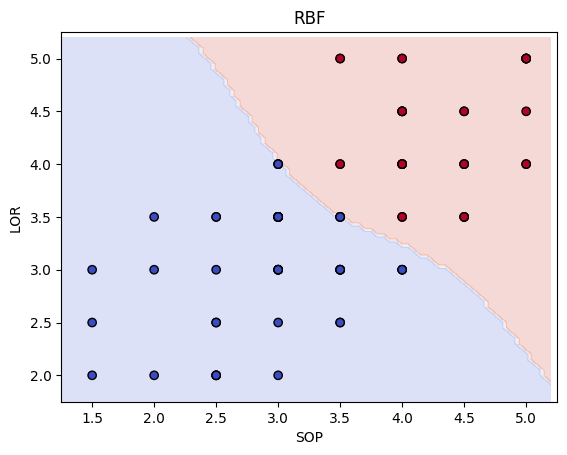

In [31]:
fig, ax = plt.subplots(1,1)
plot(ax, test_features.values, test_preds, best_model["name"], xlabel=best_model["features"][0], ylabel=best_model["features"][1], model=best_model["model"])
plt.show()

In [34]:
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# selected_features = best_model["features"]
# sklearn_svm = SVC(kernel='rbf', C=1)

# train_features = train_df.loc[train_idx, selected_features]
# train_label = label[train_idx]
# sklearn_svm.fit(train_features, train_label)

# print(test_features.head())
# sklearn_preds = sklearn_svm.predict(test_features)

# confusion = confusion_matrix(test_preds, sklearn_preds)
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('sklearn prediction')
# plt.ylabel('our prediction')
# plt.title('Confusion matrix')
# plt.show()
